In [1]:
# Load libraries
import numpy as np;
import pandas as pd;
import seaborn as sns;
import matplotlib.pyplot as plt;

from sklearn.preprocessing import StandardScaler, LabelEncoder;
from sklearn.linear_model import LinearRegression, Lasso, Ridge;
from sklearn.model_selection import train_test_split, cross_val_score, KFold;
from sklearn.metrics import mean_squared_error;

import warnings;

pd.set_option('max_column', None);
warnings.filterwarnings('ignore');

## 1. Load data

In [2]:
# Load dataset
data = pd.read_csv('AirQualityUCI/AirQualityUCI.csv', sep=';');

In [3]:
# Shape the dataset
print(data.shape);

(9471, 17)


In [4]:
# Peek at the dataset
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,Unnamed: 15,Unnamed: 16
0,10/03/2004,18.00.00,"2,6",1360.0,150.0,"11,9",1046.0,166.0,1056.0,113.0,1692.0,1268.0,"13,6","48,9","0,7578",NaN,NaN
1,10/03/2004,19.00.00,2,1292.0,112.0,"9,4",955.0,103.0,1174.0,92.0,1559.0,972.0,"13,3","47,7","0,7255",NaN,NaN
2,10/03/2004,20.00.00,"2,2",1402.0,88.0,"9,0",939.0,131.0,1140.0,114.0,1555.0,1074.0,"11,9","54,0","0,7502",NaN,NaN
3,10/03/2004,21.00.00,"2,2",1376.0,80.0,"9,2",948.0,172.0,1092.0,122.0,1584.0,1203.0,"11,0","60,0","0,7867",NaN,NaN
4,10/03/2004,22.00.00,"1,6",1272.0,51.0,"6,5",836.0,131.0,1205.0,116.0,1490.0,1110.0,"11,2","59,6","0,7888",NaN,NaN


In [5]:
# Let's check duplicated values
data[data.duplicated(keep=False)].shape

(114, 17)

In [6]:
# Delete duplicated rows
data.drop(index=data[data.duplicated(keep=False)].index.values, columns=['Unnamed: 15','Unnamed: 16'], inplace=True);
data.reset_index(drop=True);
data.shape

(9357, 15)

In [7]:
# Let's look at types of dataset
data.dtypes

Date              object
Time              object
CO(GT)            object
PT08.S1(CO)      float64
NMHC(GT)         float64
C6H6(GT)          object
PT08.S2(NMHC)    float64
NOx(GT)          float64
PT08.S3(NOx)     float64
NO2(GT)          float64
PT08.S4(NO2)     float64
PT08.S5(O3)      float64
T                 object
RH                object
AH                object
dtype: object

In [8]:
# Convert into correct type
data['Date'] = pd.to_datetime(data['Date']);
for col in ['Time', 'CO(GT)', 'C6H6(GT)', 'T', 'RH','AH']:
    if col == 'Time':
        data[col] = data[col].str.replace('.00.00', '').astype('int8');
    else:
        data[col] = data[col].str.replace(',', '.').astype(('float16'));

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9357 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           9357 non-null   datetime64[ns]
 1   Time           9357 non-null   int8          
 2   CO(GT)         9357 non-null   float16       
 3   PT08.S1(CO)    9357 non-null   float64       
 4   NMHC(GT)       9357 non-null   float64       
 5   C6H6(GT)       9357 non-null   float16       
 6   PT08.S2(NMHC)  9357 non-null   float64       
 7   NOx(GT)        9357 non-null   float64       
 8   PT08.S3(NOx)   9357 non-null   float64       
 9   NO2(GT)        9357 non-null   float64       
 10  PT08.S4(NO2)   9357 non-null   float64       
 11  PT08.S5(O3)    9357 non-null   float64       
 12  T              9357 non-null   float16       
 13  RH             9357 non-null   float16       
 14  AH             9357 non-null   float16       
dtypes: datetime64[ns](1),

## 2. EDA

In [10]:
data.columns.difference(['Date', 'Time']).values

array(['AH', 'C6H6(GT)', 'CO(GT)', 'NMHC(GT)', 'NO2(GT)', 'NOx(GT)',
       'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)',
       'PT08.S5(O3)', 'RH', 'T'], dtype=object)

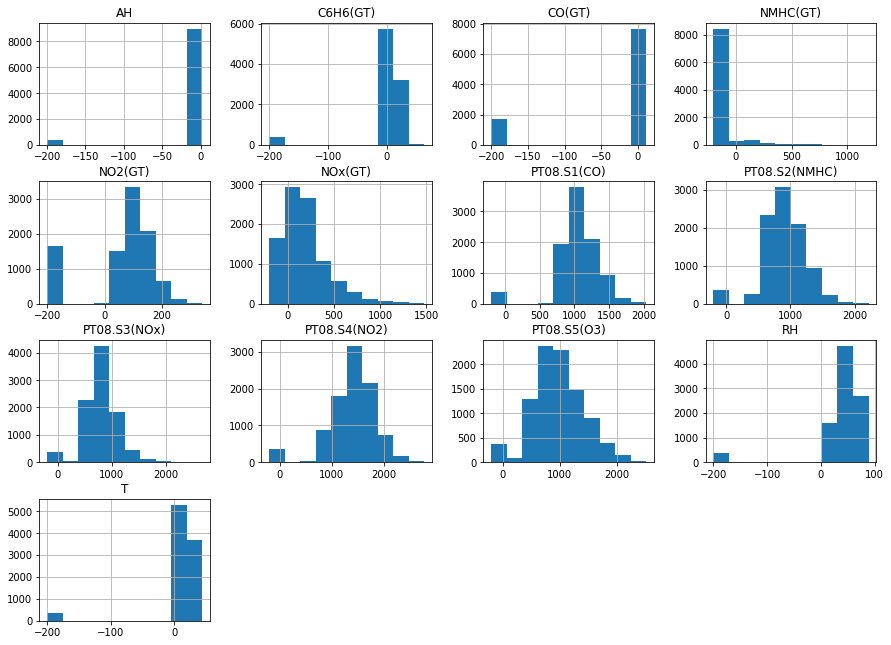

In [11]:
# Histogram
cols = data.columns.difference(['Date', 'Time']).values;
data[cols].hist(figsize=(15, 11));
plt.show()

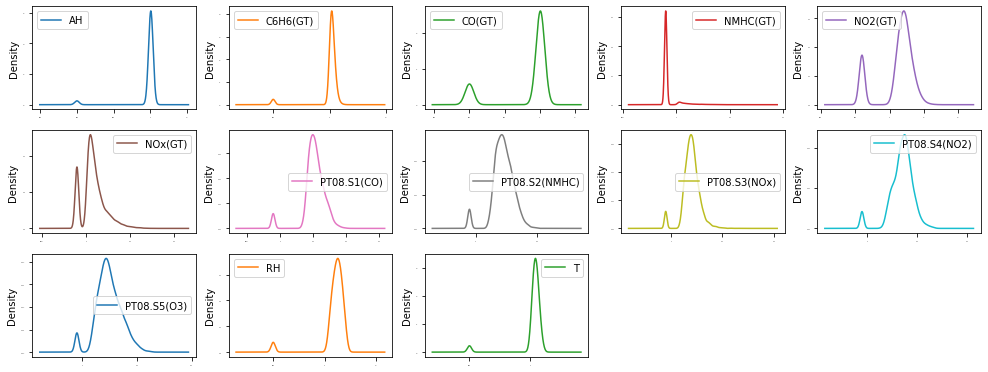

In [12]:
# Density
data[cols].plot(kind='density', subplots=True, layout=(5,5), sharex=False, legend=True, fontsize=1, figsize=(17,11));
plt.show()

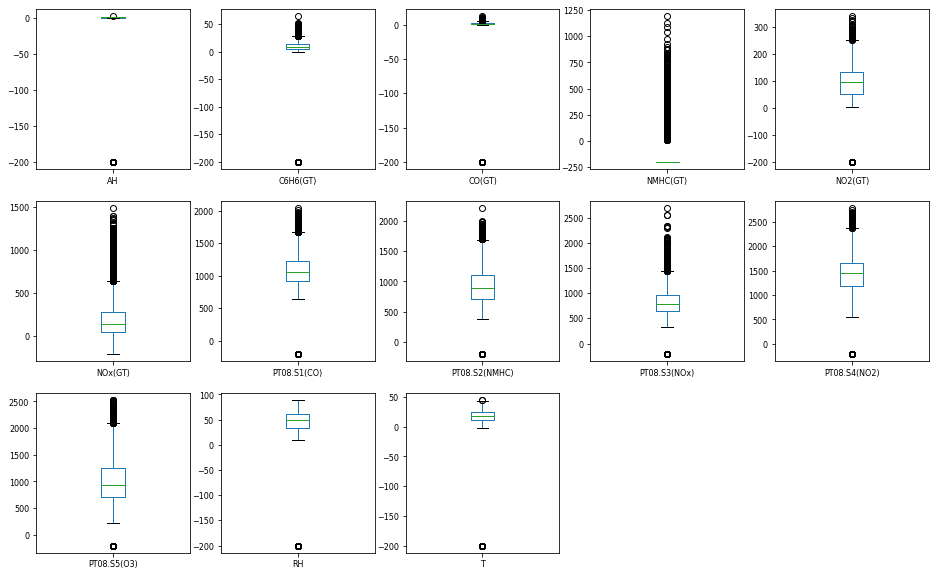

In [13]:
# Box and whisker plots
data[cols].plot(kind='box', subplots=True, layout=(3, 5), sharex=False, sharey=False, fontsize=8, figsize=(16,10));
plt.show()

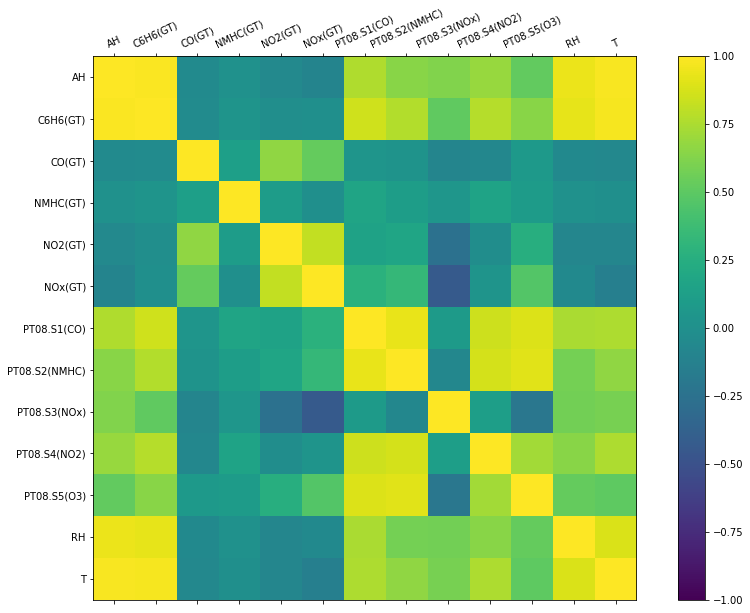

In [14]:
# Correlation matrix
fig = plt.figure(figsize=(15, 10));
ax = fig.add_subplot(111);
cax = ax.matshow(data[cols].corr(method='pearson'), vmin=-1, vmax=1);
fig.colorbar(cax);
ticks = np.arange(0, 13, 1);
ax.set_xticks(ticks);
ax.set_yticks(ticks);
ax.set_xticklabels(cols, rotation=25);
ax.set_yticklabels(cols);
plt.show()

## 3. Processing

In [15]:
# Extract date features from the date columns
for date_feature in ['year', 'month', 'day']:
    data[date_feature] = getattr(data['Date'].dt, date_feature)

## 4. Transformation

In [16]:
# Numerical
cols = data.columns.difference(['Date', 'C6H6(GT)'])
data[cols] = StandardScaler().fit_transform(data[cols])
data.head()

,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH,year,month,day
0,2004-10-03,0.939133,0.473995,0.942983,2.211236,11.898438,0.442297,-0.010166,0.810649,0.432124,0.643258,0.641101,0.088499,0.183946,0.194881,-0.562169,1.055204,-1.454161
1,2004-10-03,1.083583,0.466273,0.736807,1.939383,9.398438,0.176459,-0.254902,1.177136,0.266684,0.358574,-0.006723,0.081446,0.160149,0.194054,-0.562169,1.055204,-1.454161
2,2004-10-03,1.228033,0.468839,1.070327,1.767687,9.000000,0.129719,-0.146131,1.071538,0.440002,0.350012,0.216513,0.049076,0.283407,0.194681,-0.562169,1.055204,-1.454161
3,2004-10-03,1.372483,0.468839,0.991495,1.710454,9.203125,0.156010,0.013142,0.922459,0.503027,0.412086,0.498842,0.028279,0.400564,0.195620,-0.562169,1.055204,-1.454161
4,2004-10-03,1.516933,0.461117,0.676167,1.502988,6.500000,-0.171174,-0.146131,1.273416,0.455759,0.210881,0.295303,0.032981,0.392632,0.195671,-0.562169,1.055204,-1.454161


## 5. Split data & Fitting models

In [17]:
# Select main columns to be used in training
main_cols = data.columns.difference(['C6H6(GT)', 'Date']); 
X = data[main_cols];
y = data['C6H6(GT)']

In [18]:
# Split out test and validation dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42); # test
# X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42); # validation

# Cross validation
kfold = KFold(n_splits=3,  shuffle=True, random_state=21);

In [19]:
# Fitting
linears = [];
linears.append(('LR', LinearRegression()));
linears.append(('RIDGE', Ridge()));
linears.append(('LASSO', Lasso()));

# Evaluate
for name, model in linears:
    scores = cross_val_score(model, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold);
    print('%s : %.4f(%.4f)' % (name, -1 * scores.mean(), scores.std()));

LR : 1.0910(0.0903)
RIDGE : 1.1119(0.0835)
LASSO : 3.2535(0.2118)


## 6. Evaluate on test data

In [20]:
# Fit the best model
mod = LinearRegression();
mod = mod.fit(X_train, y_train);
y_pred = mod.predict(X_test);

In [21]:
# Evaluate each model in turn with kfold
print('Score :', mean_squared_error(y_test, y_pred));

Score : 1.2006194854804668


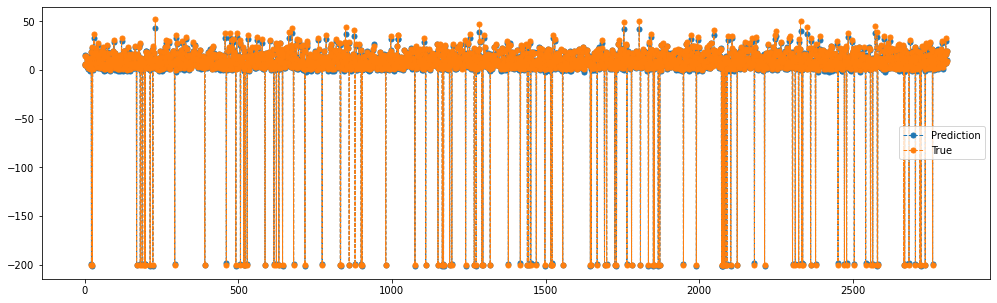

In [22]:
# Plotting predicted and true values
plt.figure(figsize=(17, 5))
plt.plot(np.arange(0, len(y_pred)), y_pred, 'o', linestyle='dashed', linewidth=1, markersize=5, label='Prediction')
plt.plot(np.arange(0, len(y_test)), y_test, 'o', linestyle='dashed', linewidth=1, markersize=5, label='True')
plt.legend()
plt.show()

## 7. Make persitent preprocessing data

In [23]:
data.to_csv('pre_air.csv', index=False);